In [23]:
import sys, subprocess,pkg_resources
required = {'numpy','matplotlib','scipy','wnutils'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

import numpy as np
import io, requests
import wnutils.xml as wx
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

recallable definitions for calculations of multiple runs

In [24]:
#parameter calculator 

#Reaction rate calculator
def rate_calc(t9,ground,meta,reac_ex,reac_dec):
    nucs = xml.get_nuclide_data()

    Q = nucs[meta]['mass excess'] - nucs[ground]['mass excess']
    gg = nucs[ground]['partf']
    t9g = nucs[ground]['t9']
    gm = nucs[meta]['partf']
    t9m = nucs[meta]['t9']

    fg = interp1d(t9g, gg)
    fm = interp1d(t9m, gm)
    
    reacs = xml.get_reaction_data()
    reac = reacs[reac_dec]

    ex_rate = []
    dec_rate = []

    for t in t9:
        r = reac.compute_rate(t)
        dec_rate.append(r)
        ex_rate.append(r * (fm(t)/fg(t)) * np.exp(-11.605 * Q / t))

    return ex_rate,dec_rate
# the followig 3 functions are for solving the 'network' via newton-raphson method 
def f1(y_85_m_dt,y_85_g_dt,y_85_m,dt,lambda_dec,lambda_ex):
    return y_85_m_dt*(1+lambda_dec*dt) - dt*lambda_ex*y_85_g_dt - y_85_m
    
def f2(y_85_m_dt,y_85_g_dt,y_85_g,dt,lambda_dec,lambda_ex):
    return y_85_g_dt*(1+dt*lambda_ex) - dt*lambda_dec*y_85_m_dt - y_85_g

def nef_raf_solver(lbda_ex,lbda_dec,t,y1,y2,y1_dt,y2_dt,y11,y22,tol):
    dt = t[1] - t[0]
    n_tot = len(t)
    for i in range(1,n_tot):
        delta = np.ones(2)
        A = np.array([[1 + lbda_dec[i]*dt, -dt*lbda_ex[i] ],[-lbda_dec[i]*dt, 1 + dt*lbda_ex[i]]])
        while (abs(max(delta)) > tol):
            b = np.array([-f1(y1_dt,y2_dt,y1,dt,lbda_dec[i],lbda_ex[i]),
            -f2(y1_dt,y2_dt,y2,dt,lbda_dec[i],lbda_ex[i])])
            delta = np.linalg.solve(A,b)
            y1_dt += delta[0]
            y2_dt += delta[1]
        y1 = y1_dt
        y2 = y2_dt
        
        y11 = np.append(y11,y1)
        y22 = np.append(y22,y2)

    return y11,y22

Cell of parameters that govern the whole run and import the network you wish to calculate your reactions based on. For this example, we use a network that contains the JINA reaction rates

Parameters and xml import

In [ ]:
# importing data from OSF
xml = wx.Xml(io.BytesIO(requests.get('https://osf.io/7463v/download').content))

#calculation parameters and flags
tol = 1e-6 #tolerance for Newton-Raphson solver
t9_0 = 0.2 #initial temperature in 10^9 K
rho_0 = 1e+3 #initial density in g/cc
den_frac = 0.5 #density scaling for oscillatory behavior
w = 10 #angular frequency

flag = 'sinusoidal' #this flag is used to determine if the temperature is constant or oscillates in time

#initializing the time array and 
t = np.linspace(0,100,1000)

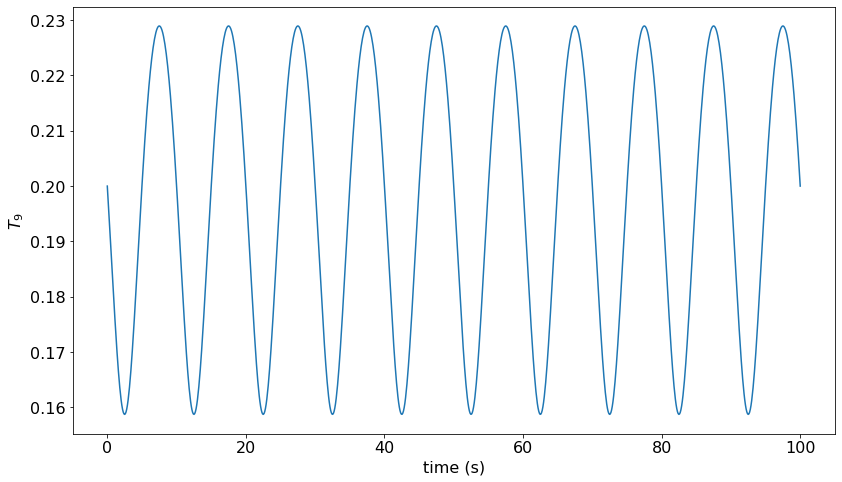

In [30]:
rho = rho_0*(1 - den_frac*np.sin(2*np.pi*t/w))
t9 = t9_0*np.power(rho,1/3)/10

#t9,rho,lambda_decay,lambda_excite = param_calc(t9_0,rho_0,lambda_decay_0,lambda_excite_0,kb,den_frac,t,flag,energy)
plt.figure(figsize=[13.66,7.86])
plt.rcParams['font.size'] = 16
plt.plot(t,t9)
plt.xlabel('time (s)')
plt.ylabel(r'$T_{9}$')
plt.show()

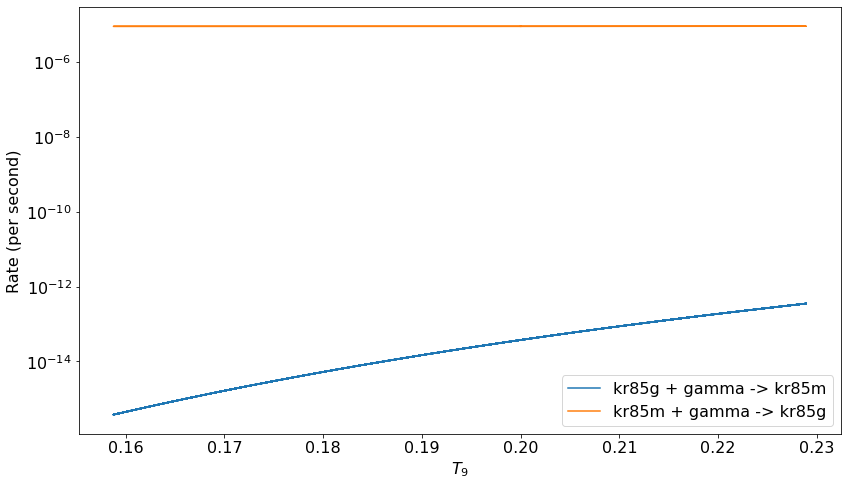

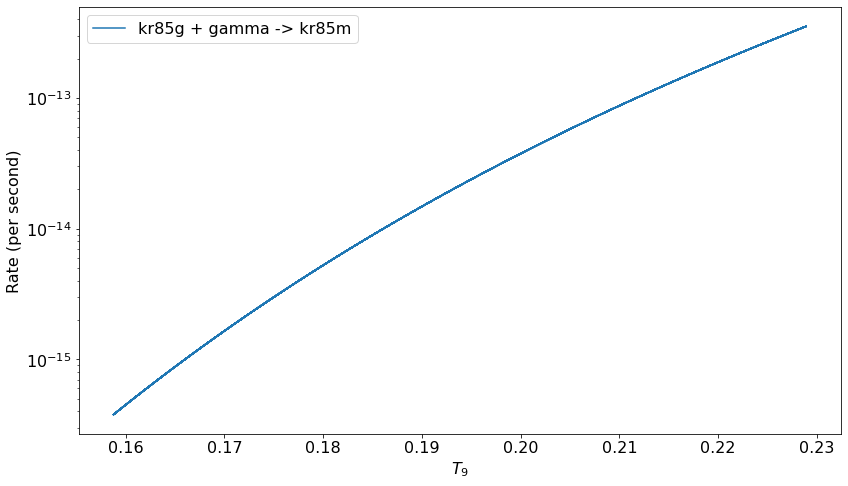

In [34]:
#choose the species and set them as strings
nuclide_g = 'kr85g' #ground state
nuclide_m = 'kr85m' #meta-stable state
#set the reactions for excitation and decay
excite_string = nuclide_g + ' + gamma -> ' + nuclide_m
decay_string = nuclide_m + ' + gamma -> ' + nuclide_g
#get the reaction rates

lambda_excite, lambda_decay = rate_calc(t9,nuclide_g,nuclide_m,excite_string,decay_string)

plt.figure(figsize=[13.66,7.86])
plt.rcParams['font.size'] = 16
plt.plot(t9,lambda_excite, label = excite_string)
plt.plot(t9,lambda_decay, label = decay_string)
#plt.xscale('log')
plt.yscale('log')
#plt.xlim([1.e-2, 10])
#plt.ylim([1.e-10, 1.e16])
plt.xlabel('$T_9$')
plt.ylabel('Rate (per second)')
plt.legend()

plt.show()

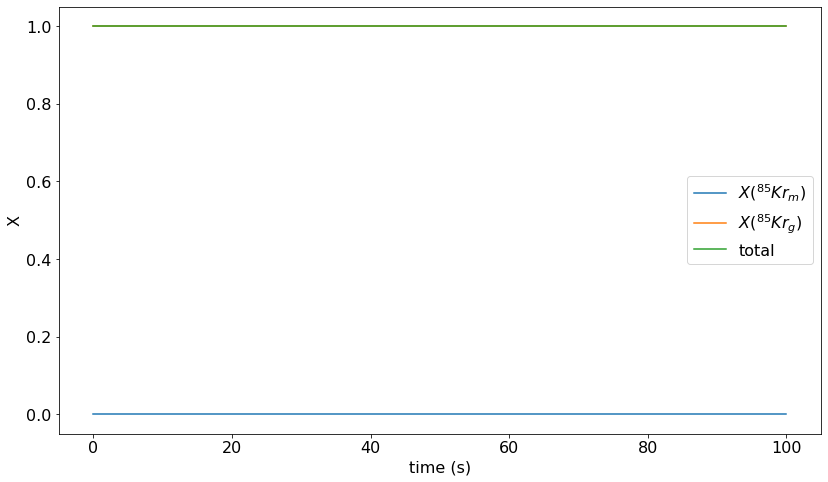

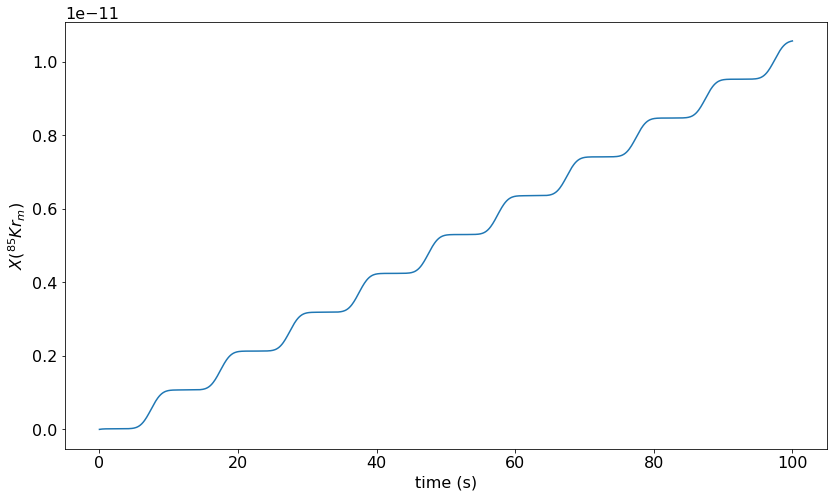

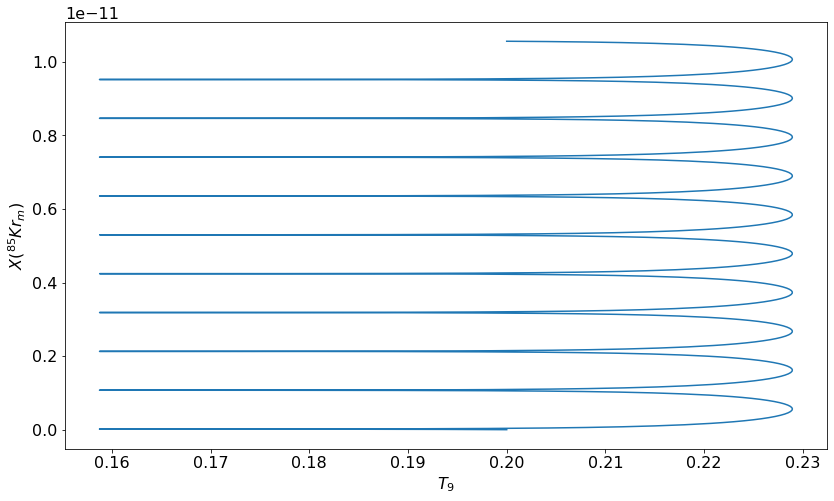

In [32]:
#at time 0
y_kr85_m = 0
y_kr85_g = 1
#initial guess
y_kr85_m_dt = y_kr85_m
y_kr85_g_dt = y_kr85_g

y_kr85_m,y_kr85_g = nef_raf_solver(lambda_excite,lambda_decay,t,y_kr85_m,y_kr85_g,y_kr85_m,y_kr85_g,y_kr85_m,y_kr85_g,tol)

plt.figure(figsize=[13.66,7.86])
plt.rcParams['font.size'] = 16
plt.plot(t,y_kr85_m,label = r'$X(^{85}Kr_{m})$')
plt.plot(t,y_kr85_g,label = r'$X(^{85}Kr_{g})$')
plt.plot(t,y_kr85_g+y_kr85_m, label = 'total')
plt.ylabel('X')
plt.xlabel('time (s)')
plt.legend()

plt.figure(figsize=[13.66,7.86])
plt.plot(t,y_kr85_m)
plt.xlabel('time (s)')
plt.ylabel(r'$X(^{85}Kr_{m})$')

plt.figure(figsize = [13.66,7.86])
plt.plot(t9,y_kr85_m)
plt.xlabel(r'$T_{9}$')
plt.ylabel(r'$X(^{85}Kr_{m})$')
plt.show()